# Resnet + transfer learning
Instead of training from scratch, we can use a pretrained model, like ResNet18 or ResNet34, with:
- frozen early layers
- fine-tuned later layers
Transfer learning can help achieve better performance and reduce training time, as the model has already learned useful features from the large dataset.

First, we will use a ResNet18 model from torchvision.models. The model will be pretrained on the ImageNet dataset, a large dataset with millions of images of many different classes. The final layer of the ResNet18 model is modified to match the binary output for our Pneumonia classification. THe first layer of the Resnet model is modified to handle grascale images. Then we will repeat training with a ResNet34 model and see which one performs best.

## Import required libraries


In [1]:
import os
import sys
import torch
from torchinfo import summary
module_path = os.path.abspath(os.path.join('..')) # project root
# add project root to sys.path
if module_path not in sys.path:
    sys.path.append(module_path) 
from src.data_loader import get_dataloader
from src.transforms import get_transforms
from src.models.utils import unfreeze_layers, get_optimizer
from src.models import resnet
from src.train import train_model
from src.evaluate import evaluate_model
from src.plot_metrics import plot_learningcurve, plot_confusionmatrix, plot_learningrate

## Configuration
Set hyperparameters and device for training. Use GPU if available, otherwise use the CPU

In [2]:
data_dir = "../data/raw/chest_xray"
batch_size = 32
epochs = 10
learning_rate = 1e-3 # good starting point for fine-tuning pretrained models
img_size = 224 #
n_channels = 1 

# get device for training
#device  = torch.accelerator.current_accelerator().type if torch.accelerator.is_available() else "cpu"
device = "cuda" if torch.cuda.is_available() else "cpu"


## Load data
The training data is augmented to improve performance and the dataset is balanced through resampling.

In [3]:
# augment and balance the data

train_transform = get_transforms(img_size,to_rgb=False,augment=True)
val_transform = get_transforms(img_size,to_rgb=False,augment=False)
# set num_workers to 0, safer on Windows with CPU
train_dataloader = get_dataloader(os.path.join(data_dir,'train'), batch_size=batch_size, num_workers=0,transform=train_transform,balance=True)
val_dataloader = get_dataloader(os.path.join(data_dir,'val'), batch_size=batch_size, num_workers=0,transform=val_transform)
test_dataloader = get_dataloader(os.path.join(data_dir,'test'), batch_size=batch_size, num_workers=0,transform=val_transform)

## 1. Resnet18 model (freeze layers)
Use a pre-trained Resnet18 model and freeze all layers except the first layer (if using grayscale images) and the final classification head. This reduces the risk of overfitting. After a few epochs we could fine-tune the model further by unfreezing some of the deeper layers, and continue training at a lower learning rate.
### Model setup

In [4]:
model_resnet18_freeze = resnet.get_resnet18(pretrained=True, grayscale=True, freeze= True).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()


head_params = [
    {'params': model_resnet18_freeze.conv1.parameters(),'lr':learning_rate},
    {'params': model_resnet18_freeze.fc.parameters(),'lr': learning_rate}
    ]
#optimizer with weightdecay
# use AdamW optimizer as it decouples weight decay from gradient update, leading to more consistent regularization and better generalization than the Adam optimizer
optimizer = torch.optim.AdamW(head_params, weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# print the model summary
summary(model_resnet18_freeze,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        (128)
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          (36,864)
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          (128)
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]      

### Train the model: warm-up/ head-only stage

In [5]:
# train for 10 epochs
metrics_history_rn18_freeze = train_model(model_resnet18_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [10:36<00:00,  3.90s/it]


  Average train loss:0.361786  
 Accuracy on the train dataset: 86.04%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.354766  
 Accuracy on the validation dataset: 84.13%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [10:22<00:00,  3.82s/it]


  Average train loss:0.219788  
 Accuracy on the train dataset: 91.89%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


  Average val loss:0.297420  
 Accuracy on the validation dataset: 88.78%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [10:26<00:00,  3.84s/it]


  Average train loss:0.195482  
 Accuracy on the train dataset: 92.29%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


  Average val loss:0.351156  
 Accuracy on the validation dataset: 86.38%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [10:26<00:00,  3.84s/it]


  Average train loss:0.182769  
 Accuracy on the train dataset: 93.33%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.46s/it]


  Average val loss:0.318192  
 Accuracy on the validation dataset: 88.78%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [10:30<00:00,  3.87s/it]


  Average train loss:0.166720  
 Accuracy on the train dataset: 93.83%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.58s/it]


  Average val loss:0.288622  
 Accuracy on the validation dataset: 88.78%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [10:14<00:00,  3.77s/it]


  Average train loss:0.156988  
 Accuracy on the train dataset: 94.19%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


  Average val loss:0.277276  
 Accuracy on the validation dataset: 88.94%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [10:14<00:00,  3.77s/it]


  Average train loss:0.160479  
 Accuracy on the train dataset: 94.17%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.49s/it]


  Average val loss:0.278418  
 Accuracy on the validation dataset: 89.42%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [10:27<00:00,  3.85s/it]


  Average train loss:0.157317  
 Accuracy on the train dataset: 94.13%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


  Average val loss:0.241814  
 Accuracy on the validation dataset: 90.71%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [10:11<00:00,  3.75s/it]


  Average train loss:0.151717  
 Accuracy on the train dataset: 94.63%


Validation: 100%|██████████| 20/20 [00:27<00:00,  1.40s/it]


  Average val loss:0.256262  
 Accuracy on the validation dataset: 90.87%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [09:49<00:00,  3.62s/it]


  Average train loss:0.145265  
 Accuracy on the train dataset: 94.56%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]

  Average val loss:0.241706  
 Accuracy on the validation dataset: 90.87%
Done!


### Train the model: Fine-tuning
Unfreeze a deeper layer (layer4) to fine-tune the model, and train again for a number of epochs


In [6]:
# unfreeze the layer 
unfreeze_layers(model_resnet18_freeze, ['layer4'], prefix=None)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#get optimizer with adapted learning rates
optimizer = get_optimizer(model_resnet18_freeze, backbone_lr=1e-4, head_lr=1e-3,backbone_prefixes=('layer','conv1'), head_prefixes=('fc',),weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

metrics_history_rn18_finetuned = train_model(model_resnet18_freeze,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [12:40<00:00,  4.66s/it]


  Average train loss:0.115551  
 Accuracy on the train dataset: 95.80%


Validation: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


  Average val loss:0.253381  
 Accuracy on the validation dataset: 91.83%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [10:40<00:00,  3.93s/it]


  Average train loss:0.063869  
 Accuracy on the train dataset: 97.78%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.41s/it]


  Average val loss:0.361128  
 Accuracy on the validation dataset: 91.03%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [10:56<00:00,  4.03s/it]


  Average train loss:0.044937  
 Accuracy on the train dataset: 98.49%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


  Average val loss:0.242934  
 Accuracy on the validation dataset: 92.63%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [10:50<00:00,  3.99s/it]


  Average train loss:0.037796  
 Accuracy on the train dataset: 98.60%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


  Average val loss:0.408783  
 Accuracy on the validation dataset: 90.54%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [10:40<00:00,  3.93s/it]


  Average train loss:0.032859  
 Accuracy on the train dataset: 98.87%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


  Average val loss:0.314786  
 Accuracy on the validation dataset: 92.63%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [10:38<00:00,  3.92s/it]


  Average train loss:0.017320  
 Accuracy on the train dataset: 99.37%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


  Average val loss:0.402073  
 Accuracy on the validation dataset: 90.71%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [10:51<00:00,  4.00s/it]


  Average train loss:0.015552  
 Accuracy on the train dataset: 99.48%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.51s/it]


  Average val loss:0.363137  
 Accuracy on the validation dataset: 92.31%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [11:18<00:00,  4.16s/it]


  Average train loss:0.010835  
 Accuracy on the train dataset: 99.67%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


  Average val loss:0.323142  
 Accuracy on the validation dataset: 92.95%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [11:27<00:00,  4.22s/it]


  Average train loss:0.010490  
 Accuracy on the train dataset: 99.64%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.50s/it]


  Average val loss:0.321119  
 Accuracy on the validation dataset: 92.63%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [10:55<00:00,  4.02s/it]


  Average train loss:0.008701  
 Accuracy on the train dataset: 99.75%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]

  Average val loss:0.353985  
 Accuracy on the validation dataset: 93.27%
Done!


### Save the model

In [7]:
# Save the model weights only to make the model portable and easier to use across different environments
torch.save(model_resnet18_freeze.state_dict(),'../models/resnet18_gradual_unfreeze_20ep_weights.pth')

### Results

Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


Accuracy on the test set: 93.27%
Precision: 0.91, Recall: 0.99, F1 score: 0.95, AUC: 0.91
classification_report :              precision    recall  f1-score   support

           0       0.98      0.84      0.90       234
           1       0.91      0.99      0.95       390

    accuracy                           0.93       624
   macro avg       0.95      0.91      0.93       624
weighted avg       0.94      0.93      0.93       624



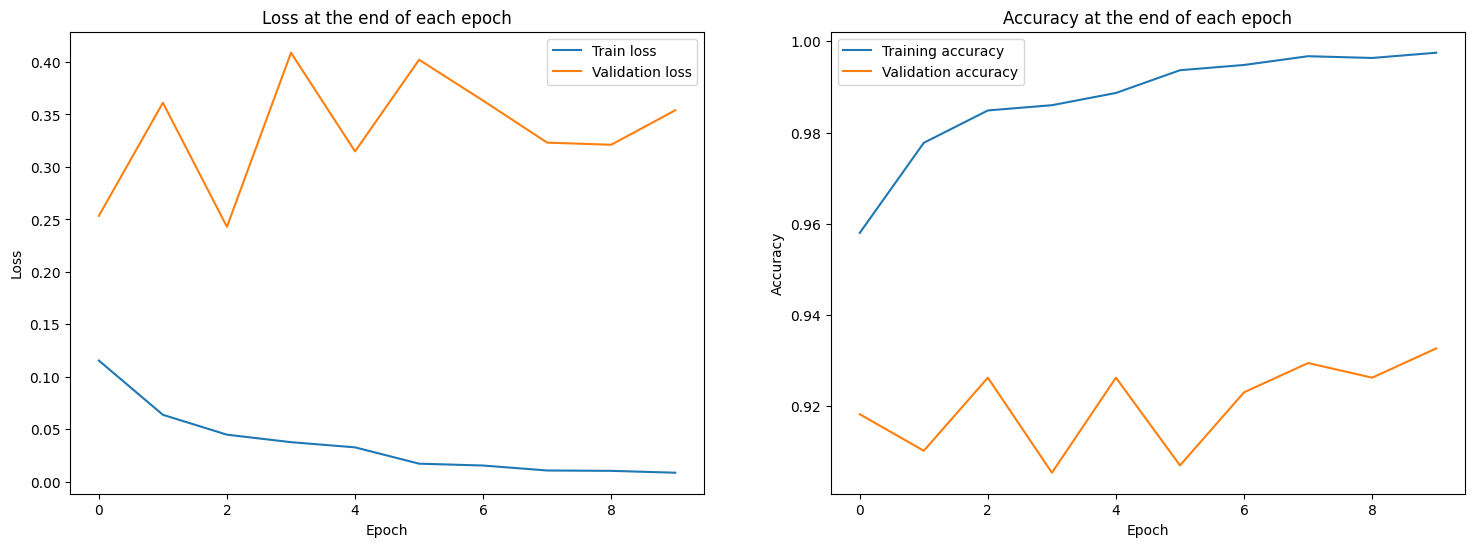

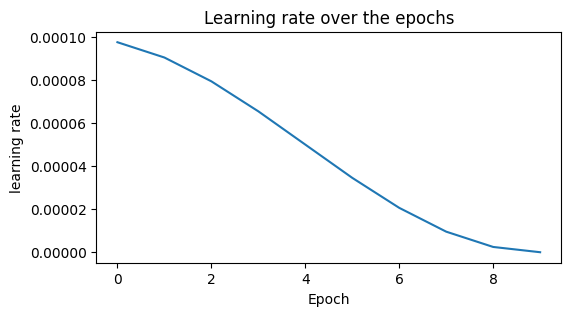

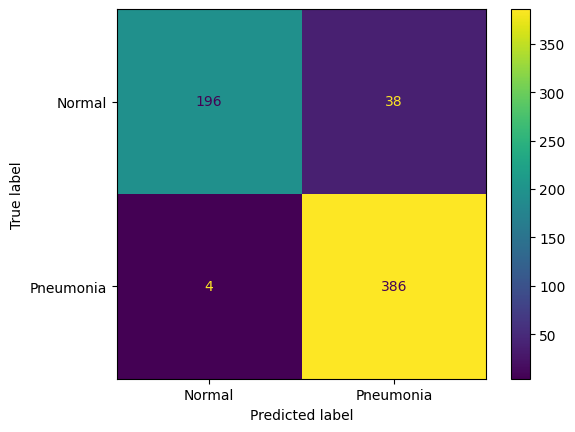

In [8]:
plot_learningcurve(metrics_history_rn18_finetuned)

plot_learningrate(metrics_history_rn18_finetuned['lrs'])

eval_metrics_rn18_finetuned = evaluate_model(model_resnet18_freeze, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn18_finetuned['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn18_finetuned['precision']:.2f}, Recall: {eval_metrics_rn18_finetuned['recall']:.2f}, F1 score: {eval_metrics_rn18_finetuned['f1']:.2f}, AUC: {eval_metrics_rn18_finetuned['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn18_finetuned['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn18_finetuned['confusion matrix'])

## 2 ResNet18 model (no freezing, all layers trainable)
let's also try to start with a pretrained ResNet18 model but allow all layers to be trainable. The model has already learned from millions of images in ImageNet dataset, and learned generic features like edges, textures and shapes. Therefore, it converges faster and requires fewer epochs and less data to reach high accuracy.
### Model setup

In [9]:
learning_rate = 1e-4 # good starting point for fine-tuning pretrained models

model_resnet18_full = resnet.get_resnet18(pretrained=True, grayscale=True, freeze= False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weightdecay
optimizer = torch.optim.AdamW(model_resnet18_full.parameters(), lr=learning_rate,weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)

# print the model summary
summary(model_resnet18_full,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

### Train the model


In [10]:
metrics_history_rn18_full = train_model(model_resnet18_full,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs=epochs,scheduler=scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [11:05<00:00,  4.08s/it]


  Average train loss:0.097480  
 Accuracy on the train dataset: 95.94%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.44s/it]


  Average val loss:0.486694  
 Accuracy on the validation dataset: 84.13%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [11:50<00:00,  4.36s/it]


  Average train loss:0.061783  
 Accuracy on the train dataset: 97.60%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]


  Average val loss:0.401306  
 Accuracy on the validation dataset: 89.42%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [11:53<00:00,  4.38s/it]


  Average train loss:0.042832  
 Accuracy on the train dataset: 98.47%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.50s/it]


  Average val loss:0.383309  
 Accuracy on the validation dataset: 87.98%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [11:51<00:00,  4.36s/it]


  Average train loss:0.031483  
 Accuracy on the train dataset: 98.87%


Validation: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]


  Average val loss:0.270821  
 Accuracy on the validation dataset: 92.47%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [11:52<00:00,  4.37s/it]


  Average train loss:0.024922  
 Accuracy on the train dataset: 99.16%


Validation: 100%|██████████| 20/20 [00:30<00:00,  1.54s/it]


  Average val loss:0.273790  
 Accuracy on the validation dataset: 92.63%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [11:52<00:00,  4.37s/it]


  Average train loss:0.013887  
 Accuracy on the train dataset: 99.62%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


  Average val loss:0.268639  
 Accuracy on the validation dataset: 92.79%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [11:48<00:00,  4.35s/it]


  Average train loss:0.015148  
 Accuracy on the train dataset: 99.50%


Validation: 100%|██████████| 20/20 [00:29<00:00,  1.48s/it]


  Average val loss:0.260953  
 Accuracy on the validation dataset: 92.31%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [11:25<00:00,  4.20s/it]


  Average train loss:0.010777  
 Accuracy on the train dataset: 99.71%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.57s/it]


  Average val loss:0.327288  
 Accuracy on the validation dataset: 91.03%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [11:46<00:00,  4.34s/it]


  Average train loss:0.010545  
 Accuracy on the train dataset: 99.71%


Validation: 100%|██████████| 20/20 [00:28<00:00,  1.42s/it]


  Average val loss:0.342550  
 Accuracy on the validation dataset: 91.03%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [11:23<00:00,  4.19s/it]


  Average train loss:0.007466  
 Accuracy on the train dataset: 99.75%


Validation: 100%|██████████| 20/20 [00:31<00:00,  1.55s/it]

  Average val loss:0.344457  
 Accuracy on the validation dataset: 91.67%
Done!


### Save the model

In [11]:
# save model weights
torch.save(model_resnet18_full.state_dict(),'../models/resnet18_pretrained_trainable_10ep_weights.pth')

### Results

Validation: 100%|██████████| 20/20 [00:30<00:00,  1.52s/it]


Accuracy on the test set: 91.67%
Precision: 0.89, Recall: 0.99, F1 score: 0.94, AUC: 0.89
classification_report :              precision    recall  f1-score   support

           0       0.98      0.79      0.88       234
           1       0.89      0.99      0.94       390

    accuracy                           0.92       624
   macro avg       0.94      0.89      0.91       624
weighted avg       0.92      0.92      0.91       624



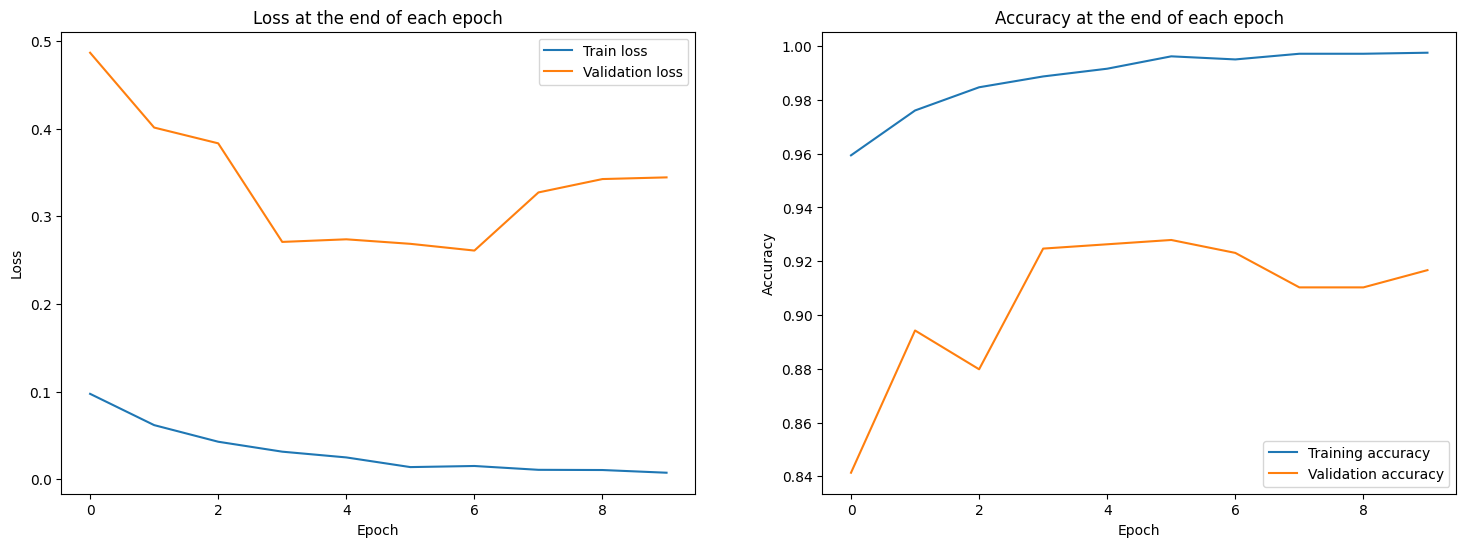

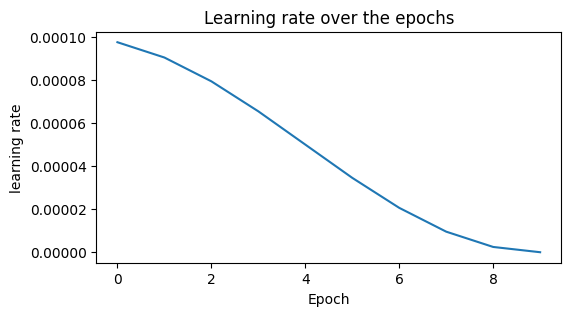

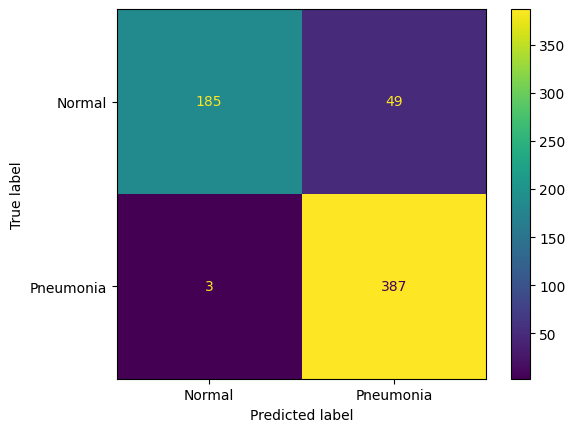

In [12]:
plot_learningcurve(metrics_history_rn18_full)

plot_learningrate(metrics_history_rn18_full['lrs'])

eval_metrics_rn18_full = evaluate_model(model_resnet18_full, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn18_full['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn18_full['precision']:.2f}, Recall: {eval_metrics_rn18_full['recall']:.2f}, F1 score: {eval_metrics_rn18_full['f1']:.2f}, AUC: {eval_metrics_rn18_full['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn18_full['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn18_full['confusion matrix'])

3. ResNet34 model (freeze layers for initialization then finetune by unfreezing last layers)

## 2. ResNet34 model (load pretrained model and allow all layers to be trainable)
For this model, let's start with a pretrained ResNet34 model and allow all layers to be trainable.
### Model setup

In [13]:
model_resnet34 = resnet.get_resnet34(pretrained=True, grayscale=True, freeze=False).to(device)

# loss function
loss_function = torch.nn.BCEWithLogitsLoss()

#optimizer with weightdecay
optimizer = torch.optim.AdamW(model_resnet34.parameters(), lr=learning_rate,weight_decay=1e-4)

# learning rate scheduler
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs)
# print the model summary
summary(model_resnet34,input_size=[batch_size,n_channels,img_size,img_size])

Layer (type:depth-idx)                   Output Shape              Param #
ResNet                                   [32, 1]                   --
├─Conv2d: 1-1                            [32, 64, 112, 112]        3,136
├─BatchNorm2d: 1-2                       [32, 64, 112, 112]        128
├─ReLU: 1-3                              [32, 64, 112, 112]        --
├─MaxPool2d: 1-4                         [32, 64, 56, 56]          --
├─Sequential: 1-5                        [32, 64, 56, 56]          --
│    └─BasicBlock: 2-1                   [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-1                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-2             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-3                    [32, 64, 56, 56]          --
│    │    └─Conv2d: 3-4                  [32, 64, 56, 56]          36,864
│    │    └─BatchNorm2d: 3-5             [32, 64, 56, 56]          128
│    │    └─ReLU: 3-6                    [32, 64, 56, 56]          --
│

### Train the model

In [14]:
metrics_history_rn34 = train_model(model_resnet34,train_dataloader,test_dataloader,optimizer, loss_function,device,epochs,scheduler)

 Epoch 1 / 10:


Training: 100%|██████████| 163/163 [16:02<00:00,  5.90s/it]


  Average train loss:0.096032  
 Accuracy on the train dataset: 96.13%


Validation: 100%|██████████| 20/20 [00:38<00:00,  1.91s/it]


  Average val loss:0.197876  
 Accuracy on the validation dataset: 93.27%
 Epoch 2 / 10:


Training: 100%|██████████| 163/163 [15:48<00:00,  5.82s/it]


  Average train loss:0.054690  
 Accuracy on the train dataset: 98.04%


Validation: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


  Average val loss:0.237272  
 Accuracy on the validation dataset: 91.83%
 Epoch 3 / 10:


Training: 100%|██████████| 163/163 [15:20<00:00,  5.65s/it]


  Average train loss:0.040793  
 Accuracy on the train dataset: 98.39%


Validation: 100%|██████████| 20/20 [00:37<00:00,  1.88s/it]


  Average val loss:0.255459  
 Accuracy on the validation dataset: 92.15%
 Epoch 4 / 10:


Training: 100%|██████████| 163/163 [16:13<00:00,  5.97s/it]


  Average train loss:0.031922  
 Accuracy on the train dataset: 98.89%


Validation: 100%|██████████| 20/20 [00:38<00:00,  1.90s/it]


  Average val loss:0.246946  
 Accuracy on the validation dataset: 92.79%
 Epoch 5 / 10:


Training: 100%|██████████| 163/163 [20:34<00:00,  7.57s/it]


  Average train loss:0.025945  
 Accuracy on the train dataset: 99.14%


Validation: 100%|██████████| 20/20 [01:55<00:00,  5.79s/it]


  Average val loss:0.470906  
 Accuracy on the validation dataset: 85.74%
 Epoch 6 / 10:


Training: 100%|██████████| 163/163 [16:32<00:00,  6.09s/it]


  Average train loss:0.013071  
 Accuracy on the train dataset: 99.64%


Validation: 100%|██████████| 20/20 [00:37<00:00,  1.87s/it]


  Average val loss:0.325621  
 Accuracy on the validation dataset: 91.83%
 Epoch 7 / 10:


Training: 100%|██████████| 163/163 [15:38<00:00,  5.76s/it]


  Average train loss:0.008467  
 Accuracy on the train dataset: 99.79%


Validation: 100%|██████████| 20/20 [00:39<00:00,  1.96s/it]


  Average val loss:0.261224  
 Accuracy on the validation dataset: 93.59%
 Epoch 8 / 10:


Training: 100%|██████████| 163/163 [15:43<00:00,  5.79s/it]


  Average train loss:0.008695  
 Accuracy on the train dataset: 99.77%


Validation: 100%|██████████| 20/20 [00:38<00:00,  1.94s/it]


  Average val loss:0.291098  
 Accuracy on the validation dataset: 92.63%
 Epoch 9 / 10:


Training: 100%|██████████| 163/163 [15:51<00:00,  5.84s/it]


  Average train loss:0.005631  
 Accuracy on the train dataset: 99.85%


Validation: 100%|██████████| 20/20 [00:37<00:00,  1.86s/it]


  Average val loss:0.348556  
 Accuracy on the validation dataset: 91.51%
 Epoch 10 / 10:


Training: 100%|██████████| 163/163 [14:51<00:00,  5.47s/it]


  Average train loss:0.005326  
 Accuracy on the train dataset: 99.83%


Validation: 100%|██████████| 20/20 [00:36<00:00,  1.84s/it]

  Average val loss:0.361247  
 Accuracy on the validation dataset: 91.35%
Done!


In [15]:
### Save the model

In [16]:
# save only the weights as a dictionary, to make the model better portable and easier to use across different projects/environments
torch.save(model_resnet34.state_dict(),'../models/resnet34_10ep_model_weights.pth')

### Results

Validation: 100%|██████████| 20/20 [00:53<00:00,  2.69s/it]


Accuracy on the test set: 91.35%
Precision: 0.88, Recall: 1.00, F1 score: 0.94, AUC: 0.89
classification_report :              precision    recall  f1-score   support

           0       0.99      0.77      0.87       234
           1       0.88      1.00      0.94       390

    accuracy                           0.91       624
   macro avg       0.94      0.89      0.90       624
weighted avg       0.92      0.91      0.91       624



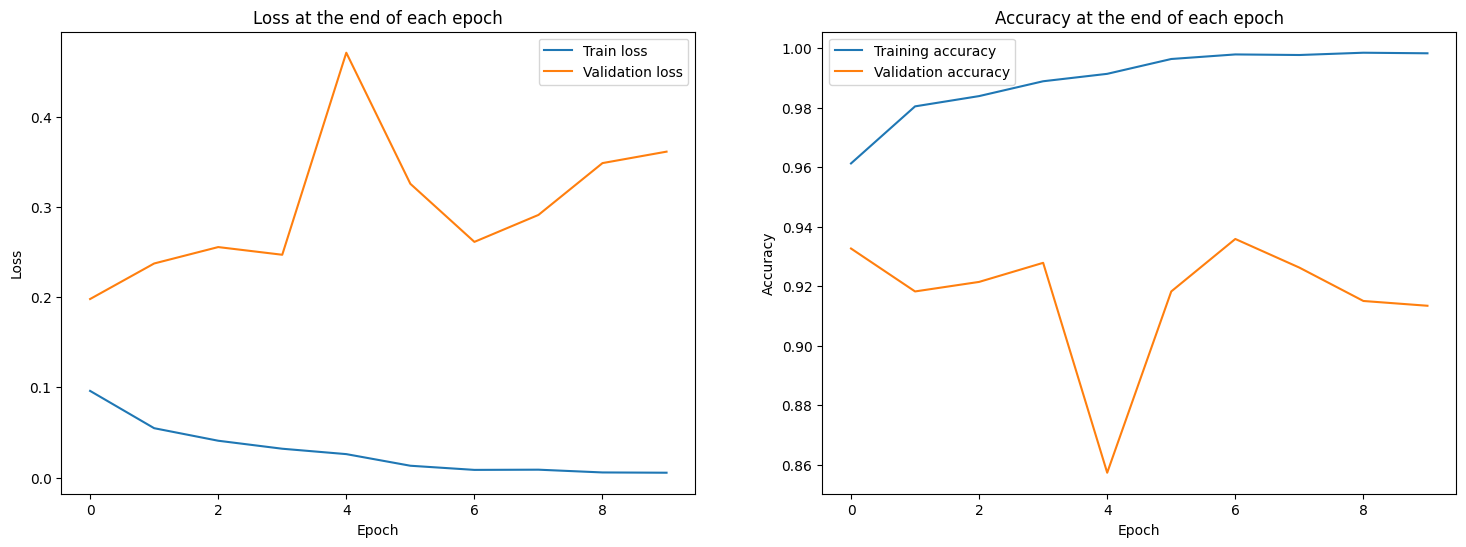

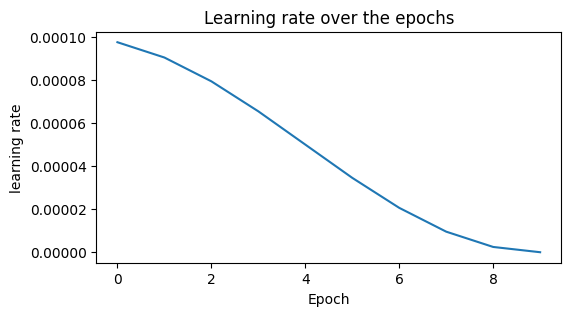

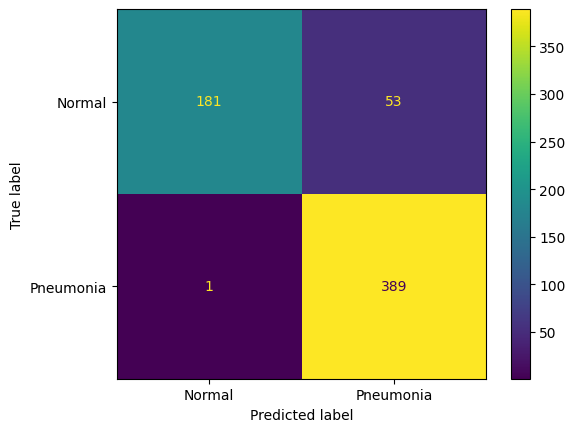

In [17]:
plot_learningcurve(metrics_history_rn34)

plot_learningrate(metrics_history_rn34['lrs'])

eval_metrics_rn34 = evaluate_model(model_resnet34, test_dataloader, loss_function, device="cpu")
       
print(f"Accuracy on the test set: {eval_metrics_rn34['accuracy']:.2%}")

print(f"Precision: {eval_metrics_rn34['precision']:.2f}, Recall: {eval_metrics_rn34['recall']:.2f}, F1 score: {eval_metrics_rn34['f1']:.2f}, AUC: {eval_metrics_rn34['auc']:.2f}")

print(f'classification_report :{eval_metrics_rn34['classification report']}')


# Calculate the confusion matrix using the true labels and predicision for the complete test set
plot_confusionmatrix(eval_metrics_rn34['confusion matrix'])